In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from PIL import Image
import cv2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [5]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize(256), 
                                transforms.CenterCrop(256)])

In [6]:
dataset = datasets.ImageFolder("archive (1)\Brain Tumor Data Set\Brain Tumor Data Set", transform=transform)
class_name = dataset.classes

In [7]:
train_size = int(0.7*(len(dataset)))
test_size = int(0.3*(len(dataset)))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=100)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=10)

Label: [0 1 0 1 1 1 1 0 1 1]
Class: Brain Tumor Healthy Brain Tumor Healthy Healthy Healthy Healthy Brain Tumor Healthy Healthy


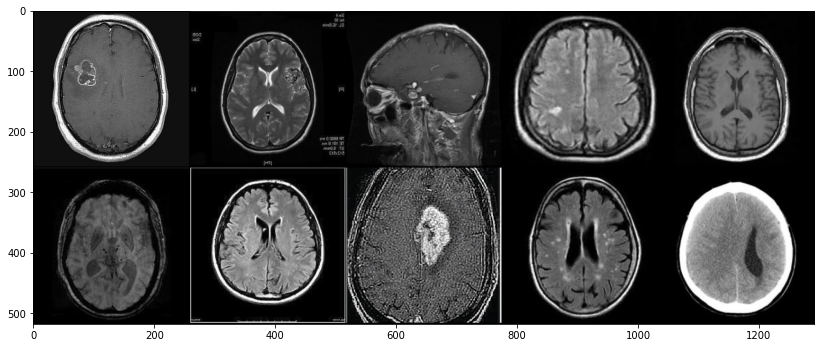

In [9]:
for image, label in test_loader:
    break

print('Label:', label.numpy())
print('Class:', *np.array([class_name[i] for i in label]))

# the default nrow is 8
im = make_grid(image, nrow=5)  

# Print the images
plt.figure(figsize=(14,6))
plt.imshow(np.transpose(im, (1, 2, 0)))

In [10]:
conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
dropout = nn.Dropout(0.5)
fc1 = nn.Linear(2*2*128, 120)
fc2 = nn.Linear(120, 2)

In [11]:
for i , (X_train,Y_train) in enumerate(train_loader):
    break

In [16]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        self.fc1 = nn.Linear(2*2*128, 120)
        self.fc2 = nn.Linear(120, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = self.dropout(X)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 128*2*2)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X, dim=1)

In [17]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   432
    16
  4608
    32
 18432
    64
 73728
   128
 61440
   120
   240
     2
______
159242


In [19]:
epoch = 1
losses = []
train_losses = []
train_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    for b,(x_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
     
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%100 == 1:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())